<a href="https://colab.research.google.com/github/dgiri1/Covid---19/blob/master/notebooks/covid_northeast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
git clone 'https://github.com/dgiri1/Covid---19.git'

Cloning into 'Covid---19'...


In [2]:
import numpy as np
import pandas as pd
import pickle
import shutil
import sys  
import pickle as pkl, pandas as pd, numpy as np, json, csv ,random, timeit, re,pymc3 as pm
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from descartes import PolygonPatch
from collections import OrderedDict
import matplotlib as mpl
from matplotlib import pyplot as plt
from collections import OrderedDict
import os
import theano
print(theano.config.__getattribute__('device'))
sys.path.insert(0, '/content/Covid---19/src')
from geo_utils import *

cpu


In [0]:
rm -r /content/Covid---19/data/mcmc_samples/parameters_covid_True_True

In [0]:
!unzip -q /content/Covid---19/data/ia_effect_samples/ia_northeast.zip -d /content/Covid---19/data/ia_effect_samples
# !mv /content/content/Covid---19/data/ia_effect_samples/* /content/Covid---19/data/ia_effect_samples/

In [0]:

num_testpoints_per_state = 500
num_partition_samples = 50

num_interaction_gaussians = 4
interaction_distance = 1000.0 #[km]
σs= 2**np.arange(num_interaction_gaussians)/(2*num_interaction_gaussians)*interaction_distance

states = OrderedDict()

In [0]:

with open("/content/Covid---19/data/gz_2010_us_040_00_500k.json", 'r') as data_file:
    shape_data = json.load(data_file)

for idx,val in enumerate(shape_data["features"]):
    id_current = val["properties"]["GEO_ID"]
    name_current = val["properties"]["NAME"]
    
    if val["geometry"]["type"] == "Polygon":
        polygon_current = Polygon(val["geometry"]["coordinates"][0],val["geometry"]["coordinates"][1:])
    elif val["geometry"]["type"] == "MultiPolygon":
        polys = [Polygon(p[0], p[1:]) for p in val["geometry"]["coordinates"]]
        polygon_current = MultiPolygon(polys)
    
    states[id_current] = {"shape": polygon_current, "name": name_current}

In [0]:
# Sanity check: the state 23 is Maine
assert states["0400000US23"]["name"] == "Maine"

In [0]:

state_names = dict([(val["name"], id) for id,val in states.items()])
state_names

In [0]:
# bring covid date and make them axis for stationary demographiscs data
# Todo account for death during the infection period and growth rate incomparison to 2018
covid = pd.read_csv('/content/Covid---19/data/disease/covid.csv', header= 0,index_col=0)
date_index = covid.index


In [0]:

age_data = pd.read_csv("Covid---19/data/sc-est2018-agesex-civ.csv")[["NAME","AGE","SEX","POPEST2018_CIV"]]

def merge_age_groups(age_group):
    starting_age = int(age_group)
    
    if starting_age <5:
        return "[0-5)"
    elif starting_age <20:
        return "[5-20)"
    elif starting_age < 65:
        return "[20-65)"
    else:
        return ">65"

age_data["AGE"] = age_data["AGE"].apply(merge_age_groups)

age_data["id"] = age_data["NAME"].apply(state_names.get)
age_data.rename(columns={'POPEST2018_CIV':'population'},inplace=True)
#get total number of people per county per year
total_population_data = age_data.groupby(["id"]).aggregate({"population": 'sum'})
#get total number of people per county per age group per year
group_population_data = age_data.groupby(["id","AGE"]).aggregate({"population": 'sum'})

#calculate the log age group fraction of the total population
log_group_fraction_data = group_population_data.apply(lambda row: np.log(row/total_population_data.loc[row.name[0]]),axis=1)#.loc[(row.name[0],row.name[2])]), axis=1)

#create group "total" column
total_population_data["AGE"]="total"
total_population_data.reset_index(inplace=True)
total_population_data.set_index(["id","AGE"], inplace=True)

#combine age groups and the "total" column into a single dataframe and export the "population" column as values in a dictionary
population_data = pd.concat([log_group_fraction_data, total_population_data])
population_data.reset_index().set_index(["id","AGE"], inplace=True)

In [0]:
## Add changes to population here before log conversion
for id,row in population_data.unstack(1).iterrows():
    
    # dt_df = pd.DataFrame(date_index)
    # dt_df['key'] = 'population'
    # t=pd.merge(row.reset_index(),dt_df, left_on = ['level_0'],right_on = ['key']).drop(columns='key').set_index(['level_0','AGE','Date'])[id]
    # states[id]["demographics"] = t.loc["population"].to_dict()

In [0]:
with open('/content/Covid---19/data/states/states_1.pkl',"rb") as f:
    states2 = pkl.load(f)
for i,(id, state) in enumerate(states.items()):
    # print("Sampling testpoints for stete '{}' ({:.2f}%)            ".format(id, 100.0*i/len(states)), end="\r")
    # # Sample uniformly in the region using local jacobian
    # centroid = np.array(state["shape"].centroid)
    # Σ_sq = jacobian_sq(centroid[1])
    # Σ_sqinv = np.diag(1/np.diag(Σ_sq))
    
    # x1,y1,x2,y2 = state["shape"].bounds
    # p1 = np.array([x1,y1])
    # p2 = np.array([x2,y2])
    
    # p1_corrected = (p1-centroid).dot(Σ_sq)
    # p2_corrected = (p2-centroid).dot(Σ_sq)
    
    # dims = p2_corrected-p1_corrected
    
    # # calculate testpoints
    # testpoints = np.empty((num_testpoints_per_state, 2), np.float)
    
    # cnt = 0
    # while cnt < num_testpoints_per_state:
    #     tp = (np.random.rand(2)*dims).dot(Σ_sqinv) + p1
    #     if not state["shape"].contains(Point(tp)):
    #         continue
    #     testpoints[cnt, :] = tp
    #     cnt += 1

    #     states[id]["testpoints"] = testpoints
    states[id]["testpoints"] = states2[id]["testpoints"]
    

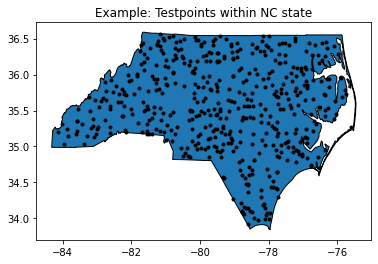

In [0]:
# plot for NC ('0400000US37', 'North Carolina')

ax = plt.subplot(111)
ax.add_patch(PolygonPatch(states["0400000US37"]["shape"]))
ax.plot(states["0400000US37"]["testpoints"][:,0],states["0400000US37"]["testpoints"][:,1], "k.")
ax.set_title("Example: Testpoints within NC state");

In [0]:
regions_df = pd.read_csv("/content/Covid---19/data/USregions.csv")
regions_df["id"] = regions_df["State"].apply(state_names.get)
regions_df.set_index("id",inplace=True)


In [0]:
regions_df.reset_index(inplace=True)
regions_df.set_index('Region').loc['West'].id.to_list()

['0400000US02',
 '0400000US04',
 '0400000US06',
 '0400000US08',
 '0400000US15',
 '0400000US16',
 '0400000US30',
 '0400000US35',
 '0400000US32',
 '0400000US41',
 '0400000US49',
 '0400000US53',
 '0400000US56']

In [0]:

regions = OrderedDict({
    "US":{"ids":list(states.keys()), "hatch": " "},
    "West": {"ids": regions_df.set_index('Region').loc['West'].id.to_list(), "hatch": "+"},
    "South": {"ids": regions_df.set_index('Region').loc['South'].id.to_list(), "hatch": "\\"},
    "Northeast": {"ids": regions_df.set_index('Region').loc['Northeast'].id.to_list(), "hatch": "/"},
    "Midwest":  {"ids": regions_df.set_index('Region').loc['Midwest'].id.to_list(), "hatch": "o"},
    "Other": {"ids": ['0400000US72'],"hatch": "--"}
})

In [0]:
for state in states.values():
    state["region"] = []

for region, props in regions.items():
    for id in props["ids"]:
        states[id]["region"].append(region)


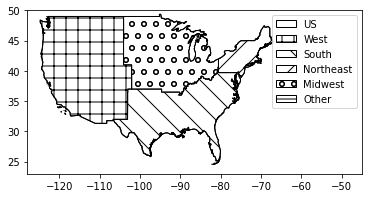

In [0]:
ax = plt.subplot(111)
# calculate region polygons
for name,region in regions.items():
    region_poly = Polygon()
    for c in region["ids"]:
        region_poly = region_poly.union(states[c]["shape"])

    # simplify polygon structure
    region_poly = region_poly.buffer(0.01).simplify(0.01).buffer(-0.01)

    region["shape"] = region_poly
    patch = PolygonPatch(region_poly, fill=False, label=name, hatch=region["hatch"])
    ax.add_patch(patch)

ax.legend()
ax.set_aspect(1.5)
y_lim = (23, 50) # lat 
x_lim = (-128, -45) # long
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plt.show()

In [0]:

# precomputed noise
ϵ = np.random.randn(num_partition_samples, 2)

for i,(id,state) in enumerate(states.items()):
  state["borderloss"] = {}
  for j,(name,region) in enumerate(regions.items()):
    if id not in region["ids"]:
      continue
    print("Calculating border effects for state '{}' in region '{}' ({:.2f}%) ".format(id, name, 100.0*((i*len(regions)+j)/(len(states)*len(regions)))), end="\r")
    state["borderloss"][name] = compute_loss(region["shape"], state["testpoints"], σs, ϵ)

In [0]:
cmap = mpl.cm.ScalarMappable(cmap=mpl.cm.viridis)
cmap.set_clim(0.0, 1.0)

fig = plt.figure(figsize=(5*len(σs), 5*len(regions)))
# calculate region polygons
for i,r in enumerate(regions.keys()):
    for j,σ in enumerate(σs):
        ax = fig.add_subplot(len(regions), 4, i*4+j+1, aspect=1.0)
        for k,(rid, state) in enumerate(states.items()):
            if r in state["borderloss"]:
                ax.add_patch(PolygonPatch(state["shape"], lw=0, fc=cmap.to_rgba(state["borderloss"][r][j])))
            else:
                ax.add_patch(PolygonPatch(state["shape"], lw=0, fill=False, hatch="x"))
        ax.set_aspect(1.5)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_title("{} @ σ = {:.2f}".format(r,σ))
plt.show(fig)

In [0]:
with open('/content/Covid---19/data/states/states_1.pkl',"wb") as f:
    pkl.dump(states,f)

In [0]:
factor = np.empty((len(states),len(states),len(σs)), np.float64)

for i,(id_1, state_1) in enumerate(states.items()):
    for j,(id_2, state_2) in enumerate(states.items()):
        if j < i:
            factor[i,j,:] = factor[j,i,:]
            continue
        print("Calculating interaction effects for states '{}' and '{}' ({:.2f}%)            ".format(id_1, id_2, 100.0*(i+j/len(states))/len(states)), end="\r")
        factor[i,j,:] = compute_interaction(state_1["testpoints"], state_2["testpoints"], σs)

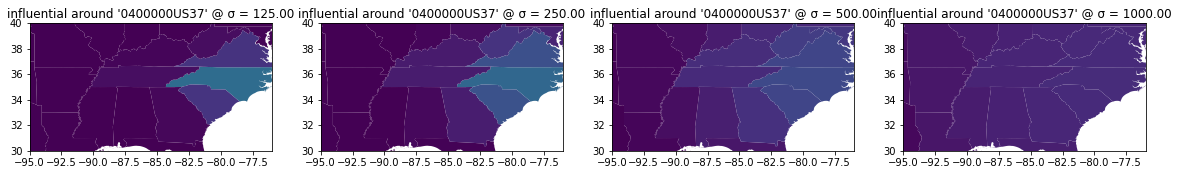

In [0]:
cmap = mpl.cm.ScalarMappable(cmap=mpl.cm.viridis)
cmap.set_clim(factor.min(), factor.max())

i = list(states.keys()).index("0400000US37")

fig = plt.figure(figsize=(5*len(σs), 5))
for j,σ in enumerate(σs):
    ax = fig.add_subplot(1, len(σs), j+1, aspect=1.0)
    for k,(rid, state) in enumerate(states.items()):
        ax.add_patch(PolygonPatch(state["shape"], lw=0, fc=cmap.to_rgba(factor[i,k,j])))
    ax.set_aspect(1.0)
    ax.set_xlim(-95,-76)
    ax.set_ylim(30,40)
    ax.set_title("influential around '0400000US37' @ σ = {:.2f}".format(σ))
plt.show(fig)

In [0]:
# read covid data countywise and aggregate to state lelve
covid = pd.read_csv('/content/Covid---19/data/usa_county_wise.zip',header=0)
covid['id'] = covid.Province_State.apply(state_names.get)
pd.pivot(covid.dropna()[['Date','Confirmed','id']]
              .groupby(['Date','id']).Confirmed.sum().reset_index(),index='Date',columns='id',values='Confirmed').to_csv('covid.csv')

In [0]:
np.save("/content/Covid---19/data/interaction_effects_1.npy", factor)

In [14]:
!pip install isoweek

In [12]:
# -*- coding: utf-8 -*-
import itertools as it, pickle as pkl, os
from collections import OrderedDict
from sampling_utils import *
from shared_utils import *

disease  = "covid"
num_sample = 100
# combinations = list(it.product(range(num_samples), diseases))
# num_sample, disease = combinations[GID-1]

filename = "/content/Covid---19/data/ia_effect_samples/{}_{}.pkl".format(disease, num_sample)

print("Running task - disease: {} - sample: {}\nWill create file {}".format(disease, num_sample, filename))

        
with open('/content/Covid---19/data/states/states_1.pkl',"rb") as f:
    states = pkl.load(f)


prediction_region = "Northeast"
parameters = OrderedDict()

# Load data
data = load_data(disease, prediction_region, states)
def uniform_times_by_day(days, n=500):
    res = OrderedDict()
    for day in days:
        time_min = datetime.datetime.combine(day.date(), datetime.time.min)
        time_max = datetime.datetime.combine(day.date(), datetime.time.max)
        res[day] = np.random.rand(n) * (time_max-time_min) + time_min
    return res
for sample_cnt in range(20,40):
  times=uniform_times_by_day(data.index)
  locs=uniform_locations_by_state(states)
  temporal_bfs = lambda x: bspline_bfs(x, np.array([0,0,1,2,3,4,5])*1*24*3600.0, 2)
  spatial_bfs = lambda x: [gaussian_bf(x,σ) for σ in [125.0, 250.0, 500.0, 1000.0]]

  samp = IAEffectSampler(data, times, locs, temporal_bfs, spatial_bfs, num_tps = 10, time_horizon=5)
  res = samp(data.index, data.columns)
  results = {"ia_effects": res, "predicted day": data.index, "predicted state": data.columns}
  filename = "/content/Covid---19/data/ia_effect_samples/{}_{}_{}.pkl".format(disease,prediction_region,sample_cnt)

  with open(filename, "wb") as file:
      pkl.dump(results, file)
  set_file_permissions(filename, uid=46836, gid=10033)

Running task - disease: covid - sample: 100
Will create file /content/Covid---19/data/ia_effect_samples/covid_100.pkl


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [0]:
%%bash
cd /content/Covid---19
# git reset
# git status
# git add src/geo_utils.py
# git add data/USregions.csv
git add data/ia_effect_samples/ia.zip
# git add	data/states/interaction_effects_1.npy
git add	src/plot_curve.py
git add	src/plot_utils.py
# cd data/mcmc_samples/
git add --all data/mcmc_samples/
git add --all data/mcmc_samples_backup/
# cd /content/Covid---19
# cd /data/mcmc_samples_backup/
# git add --all 
git status
# git add src/BaseModel.py
# git add src/shared_utils.py
git config --global user.email "dgiri@ncsu.edu"
git config --global user.name "Drishya"
git commit -m "first model"

In [4]:
!pip install isoweek

In [0]:
%%bash
cd /content/Covid---19
git remote rm origin
git remote add origin 
git push -u origin master   

Branch 'master' set up to track remote branch 'master' from 'origin'.


To https://github.com/dgiri1/Covid---19.git
   f459f45..ca105e6  master -> master


In [7]:
# sample posterior

from shared_utils import *
from BaseModel import BaseModel
import pymc3 as pm, pickle as pkl, os


num_samples = 250
num_chains = 2
num_cores = num_chains
root_dir = "/content/Covid---19"
model_complexity, disease = ((True,True),'covid')
use_age, use_eastwest     = model_complexity

if disease=="covid":
   prediction_region = "Northeast"


filename_params = "{}/data/mcmc_samples_backup/parameters_{}_{}_{}".format(root_dir,disease, use_age, use_eastwest)
filename_pred = "{}/data/mcmc_samples_backup/predictions_{}_{}_{}.pkl".format(root_dir,disease, use_age, use_eastwest)
filename_model = "{}/data/mcmc_samples_backup/model_{}_{}_{}.pkl".format(root_dir,disease, use_age, use_eastwest)

# Load data
with open(f'{root_dir}/data/states/states_1.pkl',"rb") as f:
    county_info = pkl.load(f)
data = load_data(disease, prediction_region, county_info)
data_train, target_train, data_test, target_test = split_data(data)

tspan = (target_train.index[0],target_train.index[-1])

print("training for {} in {} with model complexity {} from {} to {}\nWill create files {}, {} and {}".format(disease, prediction_region, model_complexity,*tspan, filename_params, filename_pred, filename_model))

model = BaseModel(tspan, county_info, [root_dir+"/data/ia_effect_samples/{}_Northeast_{}.pkl".format(disease, i) for i in range(40)], include_eastwest=use_eastwest, include_demographics=use_age)

print("Sampling parameters on the training set.")
trace = model.sample_parameters(target_train, samples=num_samples, tune=100, target_accept=0.95, max_treedepth=15, chains=num_chains, cores=num_cores)



training for covid in Northeast with model complexity (True, True) from 2020-01-22 00:00:00 to 2020-03-09 00:00:00
Will create files /content/Covid---19/data/mcmc_samples_backup/parameters_covid_True_True, /content/Covid---19/data/mcmc_samples_backup/predictions_covid_True_True.pkl and /content/Covid---19/data/mcmc_samples_backup/model_covid_True_True.pkl
Sampling parameters on the training set.
(630, 1, 4, 3, 3)
IA:Shape.0,T_S:(630, 4),W_t_s:Shape.0,T_T:(630, 3),W_t_t:Shape.0,TS:(630, 3),W_ts:Shape.0,S:(630, 1),W_s:Shape.0


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Only 250 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>IAEffectLoader: [IA]
>NUTS: [W_s, W_ts, W_t_t, W_t_s, W_ia, δ]
Sampling 2 chains: 100%|██████████| 700/700 [2:17:36<00:00, 11.80s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 

In [20]:
# with open(filename_model, "wb") as f:
#    pkl.dump(model.model, f)

# with model.model:
#    pm.save_trace(trace, filename_params, overwrite=True)

print("Sampling predictions on the testing set.")
pred = model.sample_predictions(target_train.sort_index().index, target_test.columns, trace)
# with open(filename_pred, 'wb') as f:
#    pkl.dump(pred, f)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


Sampling predictions on the testing set.


In [0]:
states_north = [(key,states[key]['name']) for key in states.keys() if states[key]['region'][1] =='Northeast']
n_states = len(states_north)

In [0]:
%%bash
cd /content/Covid---19/data/ia_effect_samples
zip -r ia_northeast.zip covid_Northeast_*.pkl

[]

findfont: Font family ['Bitstream Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Charter'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

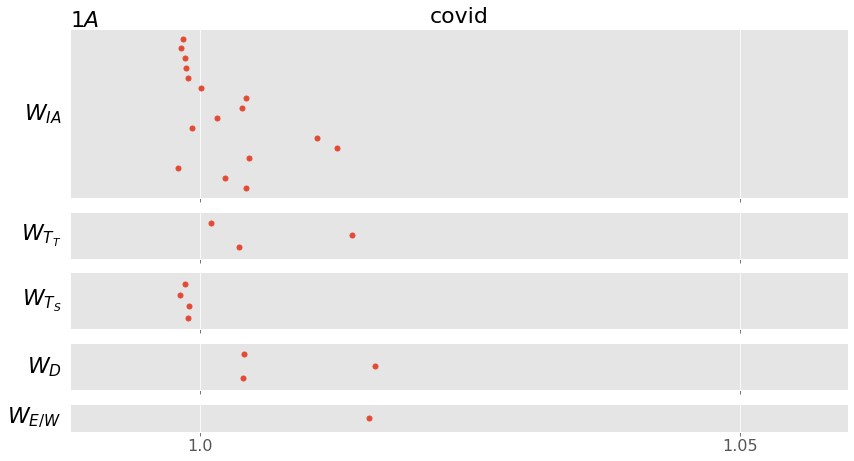

In [12]:
from shared_utils import *
from plot_utils import *
from matplotlib import pyplot as plt
from matplotlib.gridspec import SubplotSpec, GridSpec, GridSpecFromSubplotSpec
import gc
diseases =['covid']
name = {
    "covid": "covid"
}

plot_args = {
    "W_ia": {"color": "C1", "label": "$W_{IA}$", "markersize":5},
    "W_t_t": {"color": "C1", "label": "$W_{T_T}$", "markersize":5},
    "W_t_s": {"color": "C1", "label": "$W_{T_S}$", "markersize":5},
    "W_ts": {"color": "C1", "label": "$W_{D}$", "markersize":5},
    "W_s": {"color": "C1", "label": "$W_{E/W}$", "markersize":5},
}
# with open('/content/Covid---19/data/mcmc_samples_backup/model_covid_True_True.pkl','rb') as f:
#   model = pkl.load(f)
# with model:
#   trace = pm.load_trace('/content/Covid---19/data/mcmc_samples_backup/parameters_covid_True_True')
fig = plt.figure(figsize=(12, 7))
grid = GridSpec(1, len(diseases), top=0.9, bottom=0.1, left=0.07, right=0.97, hspace=0.25, wspace=0.15)
    
for i,disease in enumerate(diseases):
    use_age = True
    use_eastwest = True
        
    # trace = load_trace(disease, use_age, use_eastwest)
            
    rhatplot(trace, var_names=["W_ia", "W_t_t", "W_t_s", "W_ts", "W_s"], fig=fig, sp=grid[i], bound=1.05, ylabels=(i==0), yticks=False, yticklabels=False, var_args = plot_args, title=name[disease])
    
    bbox = grid[i].get_position(fig)
    fig.text(bbox.x0, bbox.y0+bbox.height+0.005, r"${"+str(i+1)+"ABC"[i]+r"}$", fontsize=22)

    # del trace
    gc.collect()
plt.plot()
# plt.savefig("/content/Covid---19/figures/rhat.pdf")

In [0]:

def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, var_names=varnames, figsize=(12, nrows*1.4),
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(trcs, var_names=varnames).iterrows()]))




In [14]:
var_names = ["W_ia", "W_t_t", "W_t_s", "W_ts", "W_s"]
plot_traces(trace, varnames=var_names)

TypeError: ignored

In [33]:
#  res = load_pred("covid", True, True)
 pred['y'].shape

(500, 630)

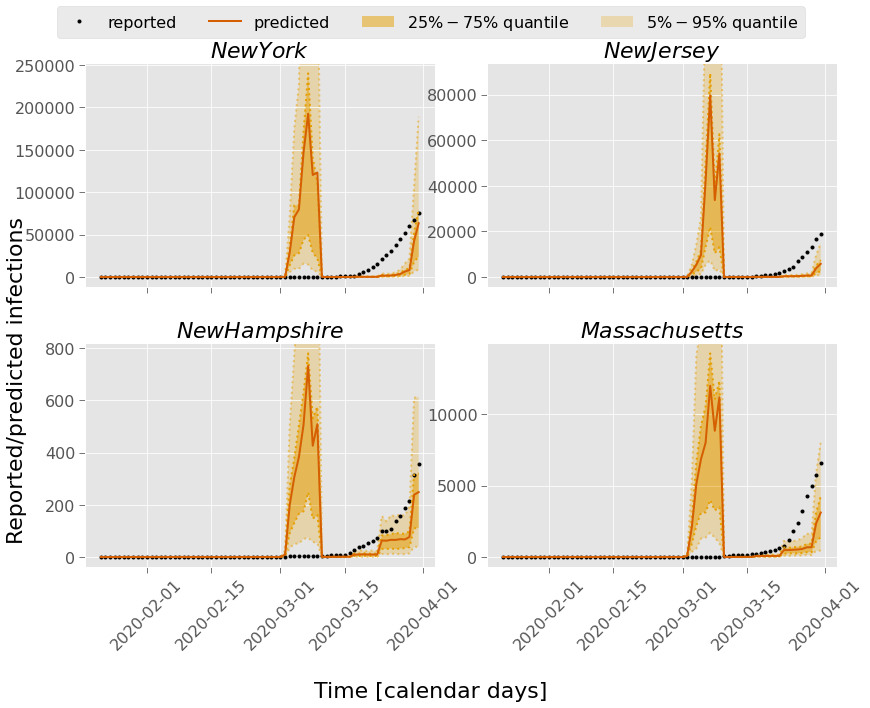

In [35]:
from matplotlib import pyplot as plt
from shared_utils import *
from plot_utils import *
import pickle as pkl
import numpy as np
from collections import OrderedDict

diseases = ["covid"]

with open(f'{root_dir}/data/states/states_1.pkl',"rb") as f:
    states = pkl.load(f)

xlim = (-110,-70)
ylim = (25,40)

# stateByName = OrderedDict([('North Carolina', '0400000US37'),('Texas', '0400000US48'),
#                             ('Florida', '0400000US12'), ('Georgia', '0400000US13')])

# plot_state_names = {"covid": ['North Carolina','Texas','Florida','Georgia']}

stateByName = OrderedDict([('New York', '0400000US36'),('New Jersey', '0400000US34'),
                            ('New Hampshire', '0400000US33'), ('Massachusetts', '0400000US25')])

plot_state_names = {"covid": ['New York','New Jersey','New Hampshire','Massachusetts']}

# colors for curves
C1 = "#D55E00"
C2 = "#E69F00"
C3 = "#0073CF"

fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(2, 2*len(diseases), top=0.9, bottom=0.2, left=0.1, right=0.97, hspace=0.25, wspace=0.15, height_ratios=[1,1])

for i,disease in enumerate(diseases):
    # Load data
    use_age = True
    use_eastwest = True
    if disease=="covid":
        prediction_region = "Northeast"
        use_eastwest = True

        
    data = load_data(disease, prediction_region, states)
    data = data[data.index < pd.Timestamp(*(2020,4,16))]
    if disease == "covid":
        data = data[data.index >= pd.Timestamp(*(2020,1,22))]
    _, _, _, target = split_data(data)
    state_ids = target.columns
    target = target_train
    # Load our prediction samples
    # res = load_pred(disease, use_age, use_eastwest)
    res = pred

    prediction_samples = np.reshape(res['y'],(res["y"].shape[0],res["y"].shape[1]//n_states,-1))
    prediction_quantiles = np.quantile(prediction_samples,q=[.05,.25,.75,.95],axis=0)

    prediction_mean = pd.DataFrame(data=np.mean(prediction_samples,axis=0), index=target.index, columns=target.columns).sort_index()
    prediction_q5 = pd.DataFrame(data=prediction_quantiles[0,:,:], index=target.index, columns=target.columns).sort_index()
    prediction_q25 = pd.DataFrame(data=prediction_quantiles[1,:,:], index=target.index, columns=target.columns).sort_index()
    prediction_q75 = pd.DataFrame(data=prediction_quantiles[2,:,:], index=target.index, columns=target.columns).sort_index()
    prediction_q95 = pd.DataFrame(data=prediction_quantiles[3,:,:], index=target.index, columns=target.columns).sort_index()



    for j,name in enumerate(plot_state_names[disease]):

        ax = fig.add_subplot(grid[j//2,j%2])

        state_id = stateByName[name]
        dates = prediction_mean.index
        # plot our predictions w/ quartiles

        p_pred=ax.plot_date(dates, prediction_mean[state_id], "-", color=C1, linewidth=2.0, zorder=4)
        p_quant=ax.fill_between(dates, prediction_q25[state_id], prediction_q75[state_id], facecolor=C2, alpha=0.5, zorder=1)
        ax.plot_date(dates,prediction_q25[state_id], ":", color=C2, linewidth=2.0, zorder=3)
        ax.plot_date(dates,prediction_q75[state_id], ":", color=C2, linewidth=2.0, zorder=3)

       
        # plot ground truth
        p_real=ax.plot_date(dates, target.loc[dates][state_id], "k.")
        # ax.axvline(dates[9], lw=2)

        ax.set_title("$"+ name +"$", fontsize=22)
        # if j == 1:
        #     ax.set_xlabel("Time [calendar weeks]", fontsize=22)
        ax.tick_params(axis="both", direction='out', size=6, labelsize=16, length=6)
        plt.setp(ax.get_xticklabels(), visible=j>1, rotation=45)


        ax.autoscale(False)
        p_quant2=ax.fill_between(dates, prediction_q5[state_id], prediction_q95[state_id], facecolor=C2, alpha=0.25, zorder=0)
        ax.plot_date(dates,prediction_q5[state_id], ":", color=C2, alpha=0.5, linewidth=2.0, zorder=1)
        ax.plot_date(dates,prediction_q95[state_id], ":", color=C2, alpha=0.5, linewidth=2.0, zorder=1)

    plt.legend([p_real[0], p_pred[0], p_quant, p_quant2],
    ["reported", "predicted", "$25\%-75\%$ quantile", "$5\%-95\%$ quantile"],
    fontsize=16, ncol=5, loc="upper center", bbox_to_anchor = (0,-0.01,1,1),
        bbox_transform = plt.gcf().transFigure )
    fig.text(0.5, 0.02, "Time [calendar days]", ha='center', fontsize=22)
    fig.text(0.01, 0.46, "Reported/predicted infections", va='center', rotation='vertical', fontsize=22)
    # plt.savefig("../figures/curves_{}_appendix.pdf".format(disease))

findfont: Font family ['Bitstream Charter'] not found. Falling back to DejaVu Sans.


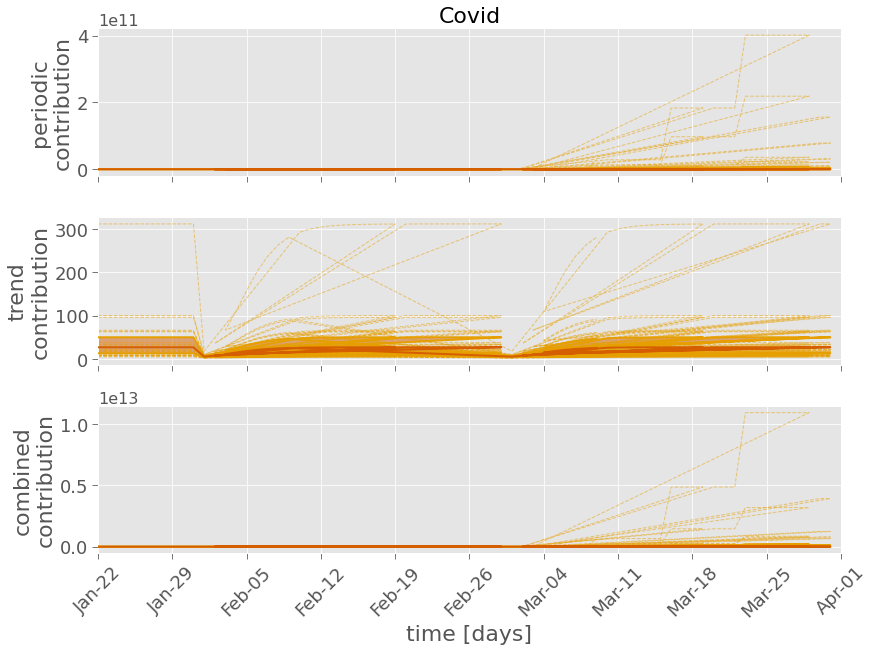

In [36]:

from pymc3.stats import quantiles
C1 = "#D55E00"
C2 = "#E69F00"
C3 = C2#"#808080"

fig = plt.figure(figsize=(12,9))
#fig.suptitle("Learned interaction kernels and temporal contributions", fontsize=20)
grid = plt.GridSpec(3, len(diseases), top=0.93, bottom=0.12, left=0.11, right=0.97, hspace=0.28, wspace=0.25)

for i,disease in enumerate(diseases):

    features = model.evaluate_features(target_train.index, target_train.columns)

    trend_features = features["temporal_trend"].swaplevel(0,1).loc["0400000US36"]
    periodic_features = features["temporal_seasonal"].swaplevel(0,1).loc["0400000US36"]
    #t_all = t_all_b if disease == "borreliosis" else t_all_cr

    trend_params = pm.trace_to_dataframe(trace, varnames=["W_t_t"])
    periodic_params = pm.trace_to_dataframe(trace, varnames=["W_t_s"])

    TT = trend_params.values.dot(trend_features.values.T)
    TP = periodic_params.values.dot(periodic_features.values.T)
    TTP = TT+TP
    TT_quantiles = quantiles(TT,(25,75))
    TP_quantiles = quantiles(TP,(25,75))
    TTP_quantiles = quantiles(TTP,(25,75))

    dates= [n for n in target_train.index]
    month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr'}
    # Temporal periodic effect
    ax_p = fig.add_subplot(grid[0,i])

    ax_p.fill_between(dates, np.exp(TP_quantiles[25]), np.exp(TP_quantiles[75]), alpha=0.5, zorder=1, facecolor=C1)
    ax_p.plot_date(dates, np.exp(TP.mean(axis=0)), "-", color=C1, lw=2, zorder=5)
    ax_p.plot_date(dates, np.exp(TP_quantiles[25]), "-", color=C2, lw=2, zorder=3)
    ax_p.plot_date(dates, np.exp(TP_quantiles[75]), "-", color=C2, lw=2, zorder=3)
    ax_p.plot_date(dates, np.exp(TP[:25,:].T), "--", color=C3, lw=1, alpha=0.5, zorder=2)

    ax_p.tick_params(axis="x", rotation=45)

    # Temporal trend effect
    ax_t = fig.add_subplot(grid[1,i], sharex=ax_p)

    ax_t.fill_between(dates, np.exp(TT_quantiles[25]), np.exp(TT_quantiles[75]), alpha=0.5, zorder=1, facecolor=C1)
    ax_t.plot_date(dates, np.exp(TT.mean(axis=0)), "-", color=C1, lw=2, zorder=5)
    ax_t.plot_date(dates, np.exp(TT_quantiles[25]), "-", color=C2, lw=2, zorder=3)
    ax_t.plot_date(dates, np.exp(TT_quantiles[75]), "-", color=C2, lw=2, zorder=3)
    ax_t.plot_date(dates, np.exp(TT[:25,:].T), "--", color=C3, lw=1, alpha=0.5, zorder=2)

    ax_t.tick_params(axis="x", rotation=45)

    # Temporal trend+periodic effect
    ax_tp = fig.add_subplot(grid[2,i], sharex=ax_p)

    ax_tp.fill_between(dates, np.exp(TTP_quantiles[25]), np.exp(TTP_quantiles[75]), alpha=0.5, zorder=1, facecolor=C1)
    ax_tp.plot_date(dates, np.exp(TTP.mean(axis=0)), "-", color=C1, lw=2, zorder=5)
    ax_tp.plot_date(dates, np.exp(TTP_quantiles[25]), "-", color=C2, lw=2, zorder=3)
    ax_tp.plot_date(dates, np.exp(TTP_quantiles[75]), "-", color=C2, lw=2, zorder=3)
    ax_tp.plot_date(dates, np.exp(TTP[:25,:].T), "--", color=C3, lw=1, alpha=0.5, zorder=2)

    ax_tp.tick_params(axis="x", rotation=45)


    # ax_p.set_xticks(np.arange(1,54))
    # ax_p.set_xticklabels(tticks_l_year)

    ax_p.set_title("Covid", fontsize=22)
    ax_tp.set_xlabel("time [days]", fontsize=22)

    if i==0:
        ax_p.set_ylabel("periodic\ncontribution", fontsize=22)
        ax_t.set_ylabel("trend\ncontribution", fontsize=22)
        ax_tp.set_ylabel("combined\ncontribution", fontsize=22)
    #elif i==2:
    ax_t.set_xlim((isoweek.Week(2020,4).wednesday(),isoweek.Week(2020,14).wednesday()))
    ax_t.set_xticks([isoweek.Week(2020,4+i).wednesday() for i in range(11)])
    ax_t.set_xticklabels([month_map[x.month]+'-'+ "{:02d}".format(x.day) for x in  (isoweek.Week(2020,4+i).wednesday() for i in range(11))])

    ax_t.tick_params(labelbottom=False, labelleft=True, labelsize=18, length=6)
    ax_p.tick_params(labelbottom=False, labelleft=True, labelsize=18, length=6)
    ax_tp.tick_params(labelbottom=True, labelleft=True, labelsize=18, length=6)

    # fig.text(0,1+0.025, r"${"+str(i+1)+r"A}$", fontsize=22, transform=ax_p.transAxes)
    # fig.text(0,1+0.025, r"${"+str(i+1)+r"B}$", fontsize=22, transform=ax_t.transAxes)
    # fig.text(0,1+0.025, r"${"+str(i+1)+r"C}$", fontsize=22, transform=ax_tp.transAxes)

plt.show()


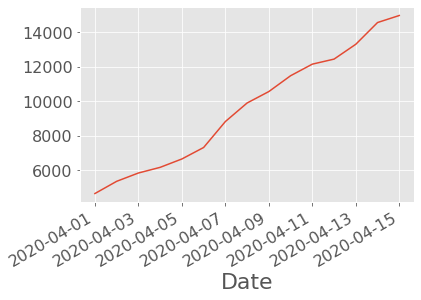

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from shared_utils import load_data, split_data, plot_counties
import pickle as pkl
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib import rc
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
plt.rcParams["font.family"] = "Bitstream Charter"

disease = "covid"
prediction_region = "South"
prediction_day = 5

xlim = (-110,-70)
ylim = (25,40)

# load models
with open('/content/Covid---19/data/mcmc_samples/model_covid_True_True.pkl',"rb") as f:
    models = pkl.load(f)


# load testing dataset
data = load_data(disease, prediction_region, model.counties)
_, _, _, _, data_test, target_test = split_data(data)
# extract county data in the same order as in the model (necessary for plotting)
contrib = model.get_linear_contributions(target_test.index, list(model.counties.keys()), data_test)
interaction = contrib["interaction"]

fig = plt.figure(figsize=(12,12))
fig.suptitle("Contribution from interaction components", fontsize=22)
grid = plt.GridSpec(4, 4)
plt.subplots_adjust(top=0.9, bottom=0.06, left=0.06, right=0.99, hspace=0.3, wspace=0.0)

for j in range(4):
    for i in range(4):
        ax = fig.add_subplot(grid[j,i])
        plot_counties(ax, model.counties, interaction[prediction_week,:,np.ravel_multi_index((i,j),(4,4))], xlim=xlim, ylim=ylim, contourcolor="black", background=(0.8,0.8,0.8,0.8), xticks=False, yticks=False, grid=False, frame=True, ylabel=False, xlabel=False, lw=2)

fig.text(0.5, 0.02, "Longitude", ha='center', fontsize=20)
fig.text(0.08, 0.47, "Latitude", va='center', rotation='vertical', fontsize=20)
plt.show()

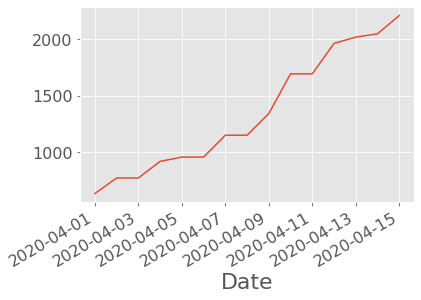

In [0]:
target['0400000US21'].plot()